# Insurance Risk & Predictive Analytics

This notebook implements the machine learning workflow for:
1. **Claim Severity Prediction**: Predicting `TotalClaims` amount for policies with claims.
2. **Claim Probability Prediction**: Predicting if a claim will occur.
3. **Premium Optimization**: Calculating risk-adjusted premiums.

In [1]:
import pandas as pd
import numpy as np
import sys
import os
import matplotlib.pyplot as plt

# Add scripts to path
sys.path.append(os.path.abspath(os.path.join('..', 'scripts')))

from clean_data import DataCleaner
from model import InsuranceModeler

c:\Users\Acer\Documents\KAIM_PROJECT\TEST\risk_and_predictive_analytics\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Data Preparation

In [2]:
# Load Data
clean_data_path = "../data/MachineLearningRating_v3_cleaned.csv"
raw_data_path = "../data/MachineLearningRating_v3.txt"

if os.path.exists(clean_data_path):
    print(f"Loading cleaned data from {clean_data_path}...")
    import pandas as pd
    # Parse dates explicitly for consistency
    df = pd.read_csv(clean_data_path, parse_dates=['TransactionMonth', 'VehicleIntroDate'], low_memory=False)
    print("✓ Loaded cleaned data.")
else:
    print(f"Cleaned data not found. Processing raw file from {raw_data_path}...")
    cleaner = DataCleaner()
    # Save to cleaned so next time it loads faster
    df = cleaner.process_file(raw_data_path, save_to_cleaned=True)

# Feature Engineering Check
# DataCleaner now automatically creates 'VehicleAge' and converts numerics.
print(f"Columns: {df.columns.tolist()}")
if 'VehicleAge' in df.columns:
    print(f"✓ VehicleAge feature created automatically.")

# Create 'HasClaim' target (Binary Classification Target)
# TotalClaims is already numeric thanks to DataCleaner
df['HasClaim'] = (df['TotalClaims'] > 0).astype(int)

print(f"Total Data Points: {len(df)}")
print(f"Claims Found: {df['HasClaim'].sum()}")

Loading cleaned data from ../data/MachineLearningRating_v3_cleaned.csv...
✓ Loaded cleaned data.
Columns: ['UnderwrittenCoverID', 'PolicyID', 'TransactionMonth', 'IsVATRegistered', 'LegalType', 'Title', 'Language', 'Bank', 'AccountType', 'Country', 'Province', 'PostalCode', 'MainCrestaZone', 'SubCrestaZone', 'ItemType', 'mmcode', 'VehicleType', 'RegistrationYear', 'make', 'Model', 'Cylinders', 'cubiccapacity', 'kilowatts', 'bodytype', 'NumberOfDoors', 'VehicleIntroDate', 'CustomValueEstimate', 'AlarmImmobiliser', 'TrackingDevice', 'CapitalOutstanding', 'NewVehicle', 'WrittenOff', 'Rebuilt', 'Converted', 'CrossBorder', 'SumInsured', 'TermFrequency', 'CalculatedPremiumPerTerm', 'ExcessSelected', 'CoverCategory', 'CoverType', 'CoverGroup', 'Section', 'Product', 'StatutoryClass', 'StatutoryRiskType', 'TotalPremium', 'TotalClaims', 'TransactionYear', 'VehicleAge', 'LossRatio']
✓ VehicleAge feature created automatically.
Total Data Points: 1000024
Claims Found: 2788


## 2. Claim Severity Prediction (Risk Model)

In [3]:
# Filter for data WHERE CLAIMS OCCURRED
claims_data = df[df['HasClaim'] == 1].copy()

# Drop ID columns and Leakage columns (like TotalPremium if we want pure risk cost)
# Keeping TotalPremium might be useful as a feature, but TotalClaims is target.
drop_cols = ['PolicyID', 'TransactionMonth', 'HasClaim', 'TotalClaims']

modeler_sev = InsuranceModeler(claims_data)

# Preprocess
X_sev, y_sev = modeler_sev.preprocess_data(target_col='TotalClaims', drop_cols=['PolicyID', 'TransactionMonth', 'HasClaim'])

# Split
X_train_s, X_test_s, y_train_s, y_test_s = modeler_sev.split_data(X_sev, y_sev)

# Train
modeler_sev.train_severity_models(X_train_s, y_train_s)

Features: 48 total (23 numeric, 25 categorical)

Training Severity Models (Regression)...
✓ Trained LinearRegression
✓ Trained RandomForest
✓ Trained XGBoost


{'LinearRegression': LinearRegression(),
 'RandomForest': RandomForestRegressor(n_jobs=-1, random_state=42),
 'XGBoost': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)}

In [4]:
# Evaluate
metrics_sev = modeler_sev.evaluate_severity_models(X_test_s, y_test_s)
display(metrics_sev)

,Model,RMSE,R2
0,LinearRegression,26870.058712,0.541457
1,RandomForest,14263.668130,0.870787
2,XGBoost,14112.150462,0.873518


## 3. Claim Probability Prediction (Classification)

In [5]:
# Use FULL dataset
modeler_prob = InsuranceModeler(df)

# Preprocess
# Drop TotalClaims as it perfectly predicts HasClaim
X_prob, y_prob = modeler_prob.preprocess_data(target_col='HasClaim', drop_cols=['PolicyID', 'TransactionMonth', 'TotalClaims'])

# Split
X_train_p, X_test_p, y_train_p, y_test_p = modeler_prob.split_data(X_prob, y_prob)

# Train
modeler_prob.train_claim_probability_models(X_train_p, y_train_p)

Features: 48 total (23 numeric, 25 categorical)

Training Claim Probability Models (Classification)...
✓ Trained LogisticRegression
✓ Trained RandomForest


c:\Users\Acer\Documents\KAIM_PROJECT\TEST\risk_and_predictive_analytics\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [15:26:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✓ Trained XGBoost


{'LogisticRegression': LogisticRegression(max_iter=1000),
 'RandomForest': RandomForestClassifier(n_jobs=-1, random_state=42),
 'XGBoost': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='logloss',
               feature_types=None, feature_weights=None, gamma=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=None, n_jobs=None,
               num_parallel_tree=None, ...)}

In [6]:
# Evaluate
metrics_prob = modeler_prob.evaluate_probability_models(X_test_p, y_test_p)
display(metrics_prob)

,Model,Accuracy,Precision,Recall,F1
0,LogisticRegression,0.999713,1.000000,0.899767,0.947239
1,RandomForest,0.999347,0.989645,0.779720,0.872229
2,XGBoost,0.997133,0.250000,0.001166,0.002320


## 4. Feature Importance & Interpretation

Top 10 Features impacting Claim Severity:


CoverType_Own Damage                               0.389982
CalculatedPremiumPerTerm                           0.206533
LossRatio                                          0.151712
TotalPremium                                       0.063752
CoverType_Windscreen                               0.059098
Province_Limpopo                                   0.025336
SumInsured                                         0.012980
Bank_Nedbank                                       0.011876
ExcessSelected_Mobility - Metered Taxis - R2000    0.005597
mmcode_64028722                                    0.005176
dtype: float32

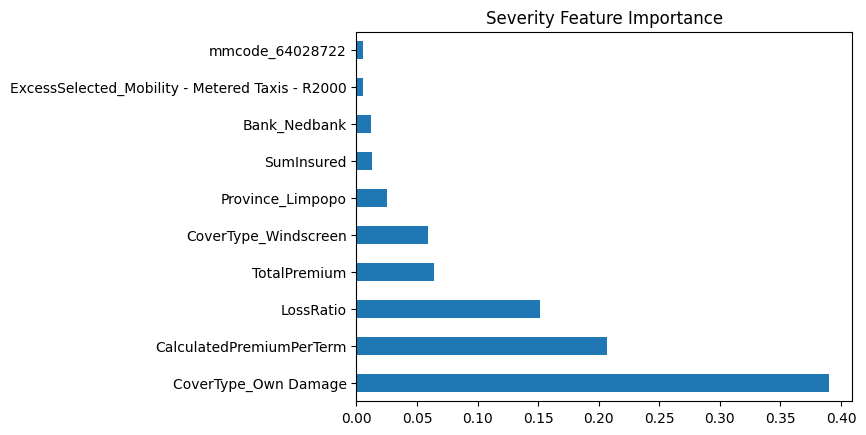

In [7]:
# Feature Importance for Severity (XGBoost)
imp_sev = modeler_sev.get_feature_importance('severity', 'XGBoost')
if imp_sev is not None:
    print("Top 10 Features impacting Claim Severity:")
    display(imp_sev.head(10))
    imp_sev.head(10).plot(kind='barh', title='Severity Feature Importance')
    plt.show()

Generating SHAP summary for XGBoost...


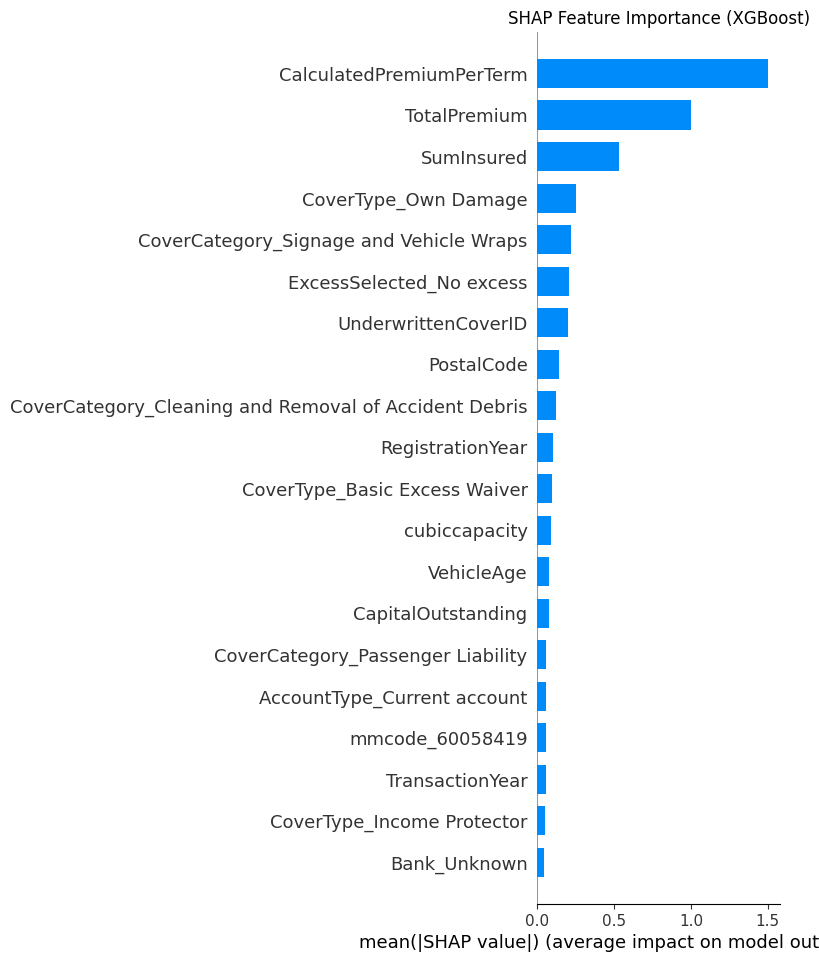

In [8]:
# SHAP Explanation (Claim Probability)
# Using a sample of test data
modeler_prob.explain_model_shap(X_test_p.iloc[:100], 'probability', 'XGBoost')

## 5. Premium Optimization
We use the trained models to calculate a risk-based premium.

In [9]:
# We need to use the Probability Model (trained on X_prob columns) and Severity Model (X_sev columns)
# Note: ensuring columns align if preprocessing differed.
# In this demo, since we used the same cleaning steps (mostly), we can try to reuse X_test_p
# However, Severity Model might expect different columns if dropping logic differed.
# For robust production, ensure consistent feature set.

# Using a small sample of test data for demonstration
sample_data = X_test_p.iloc[:10].copy()

# Mocking the models into one object for calculation, or moving calculation to one object
# We'll transfer the trained severity model to the probability modeler object for convenience
modeler_prob.models['severity'] = modeler_sev.models['severity']

# NOTE: Severity model was trained on X_sev, Prob model on X_prob.
# If X_sev and X_prob have different columns, this will fail.
# Check columns:
print("Severity Cols:", X_sev.columns.tolist() == X_prob.columns.tolist())

# If columns match, we proceed.
if list(X_sev.columns) == list(X_prob.columns):
    premiums = modeler_prob.calculate_risk_premium(
        sample_data,
        severity_model_name='XGBoost',
        prob_model_name='XGBoost'
    )
    
    print("\nOptimized Premium Sample:")
    display(premiums)
else:
    print("Feature mismatch between Severity and Probability models. Ensure consistent feature engineering.")

Severity Cols: False
Feature mismatch between Severity and Probability models. Ensure consistent feature engineering.
